In [1]:
#Step 1: Load the Data

import pandas as pd

mcdonalds = pd.read_csv("mcdonalds.csv")



print(mcdonalds.head(3))


  yummy convenient spicy fattening greasy fast cheap tasty expensive healthy  \
0    No        Yes    No       Yes     No  Yes   Yes    No       Yes      No   
1   Yes        Yes    No       Yes    Yes  Yes   Yes   Yes       Yes      No   
2    No        Yes   Yes       Yes    Yes  Yes    No   Yes       Yes     Yes   

  disgusting Like  Age      VisitFrequency  Gender  
0         No   -3   61  Every three months  Female  
1         No   +2   51  Every three months  Female  
2         No   +1   62  Every three months  Female  


In [2]:
print(mcdonalds.columns)


Index(['yummy', 'convenient', 'spicy', 'fattening', 'greasy', 'fast', 'cheap',
       'tasty', 'expensive', 'healthy', 'disgusting', 'Like', 'Age',
       'VisitFrequency', 'Gender'],
      dtype='object')


In [3]:
print(mcdonalds.shape)

(1453, 15)


In [4]:
print(mcdonalds.head(3))


  yummy convenient spicy fattening greasy fast cheap tasty expensive healthy  \
0    No        Yes    No       Yes     No  Yes   Yes    No       Yes      No   
1   Yes        Yes    No       Yes    Yes  Yes   Yes   Yes       Yes      No   
2    No        Yes   Yes       Yes    Yes  Yes    No   Yes       Yes     Yes   

  disgusting Like  Age      VisitFrequency  Gender  
0         No   -3   61  Every three months  Female  
1         No   +2   51  Every three months  Female  
2         No   +1   62  Every three months  Female  


In [5]:
#Step 2: Prepare Data for Analysis

MD_x = mcdonalds.iloc[:, 0:11].applymap(lambda x: 1 if x == 'Yes' else 0)

# Calculating and displaying the column means, rounded to 2 decimal places
print(MD_x.mean().round(2))

yummy         0.55
convenient    0.91
spicy         0.09
fattening     0.87
greasy        0.53
fast          0.90
cheap         0.60
tasty         0.64
expensive     0.36
healthy       0.20
disgusting    0.24
dtype: float64


[0.29944723 0.19279721 0.13304535 0.08309578 0.05948052 0.05029956
 0.0438491  0.03954779 0.0367609  0.03235329 0.02932326]


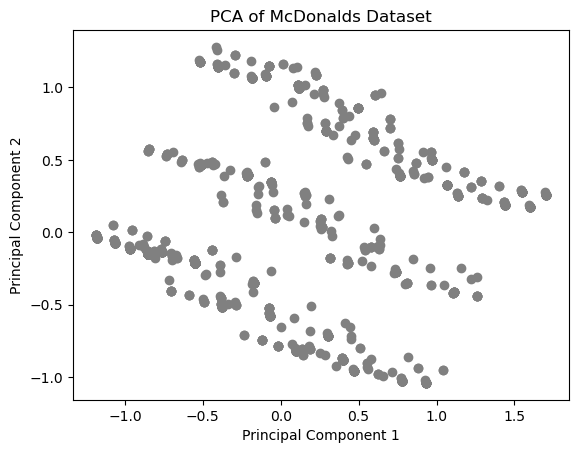

In [6]:
#Step 3: Principal Component Analysis (PCA)

from sklearn.decomposition import PCA
import matplotlib.pyplot as plt

# Perform PCA
pca = PCA()
MD_pca = pca.fit_transform(MD_x)

# Print explained variance ratio
print(pca.explained_variance_ratio_)

# Plot PCA
plt.scatter(MD_pca[:, 0], MD_pca[:, 1], color='grey')
plt.xlabel('Principal Component 1')
plt.ylabel('Principal Component 2')
plt.title('PCA of McDonalds Dataset')
plt.show()


In [7]:
#Step 4: KMeans Clustering

from sklearn.cluster import KMeans

# KMeans clustering for 2 to 8 clusters
kmeans_results = {}
for k in range(2, 9):
    kmeans = KMeans(n_clusters=k, n_init=10, random_state=1234)
    kmeans.fit(MD_x)
    kmeans_results[k] = kmeans


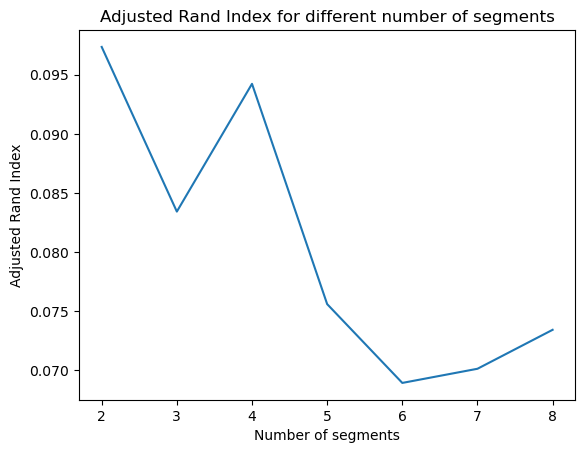

In [8]:
#Step 5: Evaluate Clustering using Adjusted Rand Index

from sklearn.metrics import adjusted_rand_score

# Calculate Adjusted Rand Index for different cluster numbers
ari_scores = {}
for k, kmeans in kmeans_results.items():
    ari_scores[k] = adjusted_rand_score(mcdonalds['Like'], kmeans.labels_)

# Plot Adjusted Rand Index
plt.plot(list(ari_scores.keys()), list(ari_scores.values()))
plt.xlabel('Number of segments')
plt.ylabel('Adjusted Rand Index')
plt.title('Adjusted Rand Index for different number of segments')
plt.show()


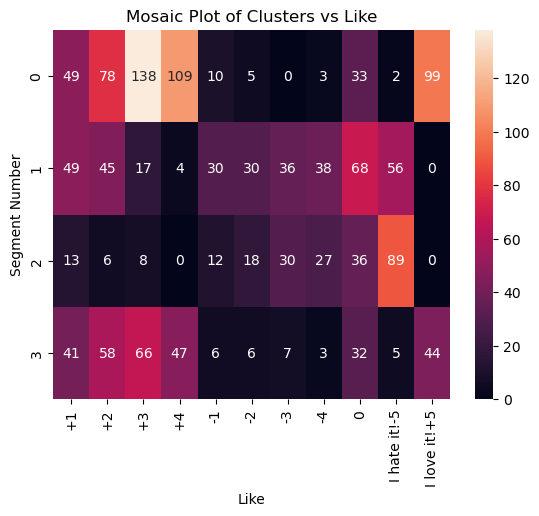

In [9]:
#Step 6: Analyze Clusters


import seaborn as sns

# Choose 4 clusters for further analysis
k4 = kmeans_results[4].labels_

# Create a contingency table for kmeans and original 'Like' ratings
contingency_table = pd.crosstab(k4, mcdonalds['Like'])
sns.heatmap(contingency_table, annot=True, fmt="d")
plt.xlabel('Like')
plt.ylabel('Segment Number')
plt.title('Mosaic Plot of Clusters vs Like')
plt.show()


In [14]:
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.tree import DecisionTreeClassifier, plot_tree

# Assuming the dataset is loaded and k4 is defined

# Convert 'Like' to numerical score
mcdonalds['Like.n'] = 6 - pd.to_numeric(mcdonalds['Like'], errors='coerce')

# Encode 'VisitFrequency'
visit_freq_mapping = {
    'Never': 0,
    'Once a year': 1,
    'Every three months': 2,
    'Once a month': 3,
    'Once a week': 4,
    'More than once a week': 5,
}
mcdonalds['VisitFrequency'] = mcdonalds['VisitFrequency'].map(visit_freq_mapping)

# Encode 'Gender'
mcdonalds['Gender'] = mcdonalds['Gender'].map({'Female': 1, 'Male': 0})

# Check for NaN values
print(mcdonalds[['Like.n', 'VisitFrequency', 'Gender']].isnull().sum())

# Fill NaN values with the column mean (or another appropriate method)
mcdonalds['Like.n'].fillna(mcdonalds['Like.n'].mean(), inplace=True)

# Debugging: Print unique values and their counts in 'VisitFrequency'
print(mcdonalds['VisitFrequency'].value_counts())

# For 'VisitFrequency' and 'Gender', fill NaN values with the most common value
mcdonalds['VisitFrequency'].fillna(mcdonalds['VisitFrequency'].mode()[0], inplace=True)
mcdonalds['Gender'].fillna(mcdonalds['Gender'].mode()[0], inplace=True)

# Features and target variable
X = mcdonalds[['Like.n', 'Age', 'VisitFrequency', 'Gender']]
y = (k4 == 3).astype(int)  # Assuming segment 3 is the target segment

# Check for any remaining NaN values
print(X.isnull().sum())

# Fit the decision tree classifier
ctree = DecisionTreeClassifier(random_state=1234)
ctree.fit(X, y)

# Plot the tree
plt.figure(figsize=(20, 10))
plot_tree(ctree, feature_names=X.columns, filled=True, class_names=['Not Segment 3', 'Segment 3'])
plt.show()

# Cluster Analysis Visualization
visit = mcdonalds.groupby(k4)['VisitFrequency'].mean()
like = mcdonalds.groupby(k4)['Like.n'].mean()
female = mcdonalds.groupby(k4)['Gender'].apply(lambda x: (x == 1).mean())  # Assuming Female is encoded as 1

plt.scatter(visit, like, s=1000 * female)
for i in range(len(visit)):
    plt.text(visit.iloc[i], like.iloc[i], str(i+1))
plt.xlabel('Visit Frequency')
plt.ylabel('Like Rating')
plt.title('Clusters Analysis')
plt.show()





Like.n             295
VisitFrequency    1453
Gender            1453
dtype: int64
Series([], Name: VisitFrequency, dtype: int64)


KeyError: 0

posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values


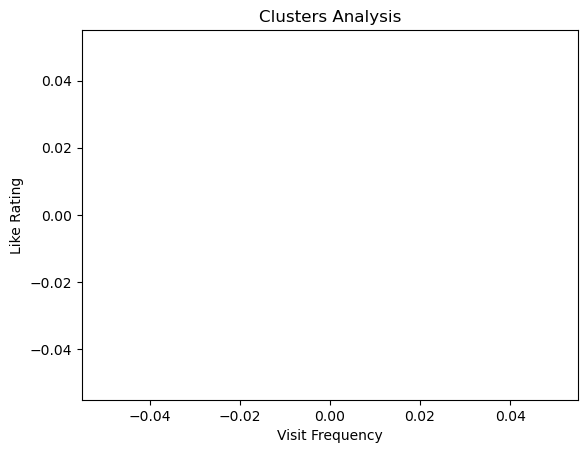

In [15]:
visit = mcdonalds.groupby(k4)['VisitFrequency'].mean()
like = mcdonalds.groupby(k4)['Like.n'].mean()
female = mcdonalds.groupby(k4)['Gender'].apply(lambda x: (x == 'Female').mean())

plt.scatter(visit, like, s=1000 * female)
for i in range(len(visit)):
    plt.text(visit.iloc[i], like.iloc[i], str(i+1))
plt.xlabel('Visit Frequency')
plt.ylabel('Like Rating')
plt.title('Clusters Analysis')
plt.show()